Huffman Compression Ratio: 2.84


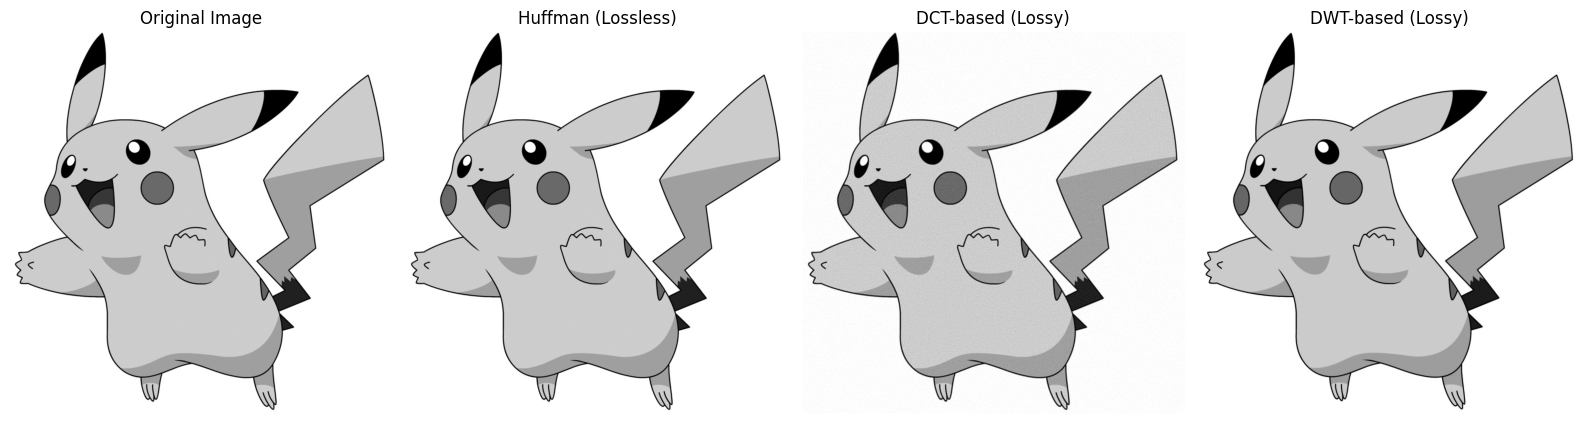

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop
import pywt


img = cv2.imread('../images/img7.png', cv2.IMREAD_GRAYSCALE)


def build_frequency_table(data):
    freq = {}
    for symbol in data:
        freq[symbol] = freq.get(symbol, 0) + 1
    return freq

def build_huffman_tree(freq):
    heap = [[weight, [symbol, ""]] for symbol, weight in freq.items()]
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def huffman_encode(data, huffman_table):
    huff_dict = {a[0]: a[1] for a in huffman_table}
    encoded = ''.join(huff_dict[sym] for sym in data)
    return encoded, huff_dict

def huffman_decode(encoded, huff_dict):
    rev_dict = {v: k for k, v in huff_dict.items()}
    decoded = []
    code = ""
    for bit in encoded:
        code += bit
        if code in rev_dict:
            decoded.append(rev_dict[code])
            code = ""
    return np.array(decoded, dtype=np.uint8)

data = img.flatten()
freq = build_frequency_table(data)
huffman_table = build_huffman_tree(freq)
encoded_data, huff_dict = huffman_encode(data, huffman_table)
decoded_data = huffman_decode(encoded_data, huff_dict)
img_huffman = decoded_data.reshape(img.shape)


def dct2(block):
    return cv2.dct(np.float32(block))

def idct2(block):
    return cv2.idct(np.float32(block))

dct_img = dct2(img)
threshold_dct = 20
dct_compressed = dct_img * (np.abs(dct_img) > threshold_dct)
img_dct = idct2(dct_compressed)
img_dct = np.clip(img_dct, 0, 255).astype(np.uint8)

coeffs2 = pywt.dwt2(img, 'haar')
cA, (cH, cV, cD) = coeffs2
threshold_dwt = 10
cA_c = pywt.threshold(cA, threshold_dwt, mode='soft')
cH_c = pywt.threshold(cH, threshold_dwt, mode='soft')
cV_c = pywt.threshold(cV, threshold_dwt, mode='soft')
cD_c = pywt.threshold(cD, threshold_dwt, mode='soft')
img_dwt = pywt.idwt2((cA_c, (cH_c, cV_c, cD_c)), 'haar')
img_dwt = np.clip(img_dwt, 0, 255).astype(np.uint8)


titles = ['Original Image', 'Huffman (Lossless)', 'DCT-based (Lossy)', 'DWT-based (Lossy)']
images = [img, img_huffman, img_dct, img_dwt]

plt.figure(figsize=(16, 5))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
# plt.show()
plt.savefig('comparison.png')
print(f"Huffman Compression Ratio: {len(data)*8 / len(encoded_data):.2f}")
